# Quantum Protein Folding — Hackathon Showcase

**Project:** Quantum-inspired HP protein folding using QAOA-style Hamiltonian encoding on a BCC lattice  
**Author:** Bhuvan  
**Purpose:** Demonstrate a clear, reproducible workflow for encoding the Hydrophobic–Polar (HP) model as a Pauli-sum Hamiltonian suitable for QAOA and classical heuristic optimization. This notebook is organized for judges: background, implementation details, experiments and visualization.

**Contents**
- Background & problem statement  
- Lattice construction (BCC)  
- Hamiltonian construction (contacts + constraints)  
- Fast classical evaluation and heuristics (hill-climb, random sampling)  
- Result visualization and constraint checks

_Recommended environment:_ Python 3.8+, Qiskit, NumPy, NetworkX, Matplotlib.


In [2]:
# Install required packages if needed.
!pip install qiskit numpy networkx matplotlib tqdm


## Imports

All imports are grouped here. We keep Qiskit primitives for later quantum evaluation, but the notebook focuses on Hamiltonian construction and efficient classical evaluation of candidate bitstrings.


In [3]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator

from tqdm import trange
import random


## Problem parameters

Define the protein sequence (HP model), lattice dimensions and derived parameters such as number of qubits (bits per residue × residues).


In [4]:
# Problem parameters
protein_sequence = "HHPHPH"      # Example HP sequence
num_residues = len(protein_sequence)

# Lattice: m × m × m BCC unit cells
lattice_dim = 2                  # small demo value

# Derived values filled after lattice construction
bits_per_residue = None
num_lattice_nodes = None
num_qubits = None


## BCC lattice construction

We build a body-centered cubic lattice by adding corner and body-center nodes for each unit cell, then connecting nodes that are within a small Euclidean distance threshold.


In [5]:
def build_bcc_lattice(m=2):
    lattice_graph = nx.Graph()
    node_coords = []

    for x in range(m):
        for y in range(m):
            for z in range(m):
                node_coords.append((x, y, z))                     # corner
                node_coords.append((x+0.5, y+0.5, z+0.5))         # body center

    for node_id, coord in enumerate(node_coords):
        lattice_graph.add_node(node_id, pos=coord)

    for i in lattice_graph.nodes:
        for j in lattice_graph.nodes:
            if i < j:
                dist = np.linalg.norm(np.array(lattice_graph.nodes[i]['pos']) -
                                      np.array(lattice_graph.nodes[j]['pos']))
                if dist < 1.1:
                    lattice_graph.add_edge(i, j)

    return lattice_graph, node_coords

# Build lattice and derived parameters
lattice_graph, lattice_coords = build_bcc_lattice(lattice_dim)
num_lattice_nodes = len(lattice_graph.nodes)
bits_per_residue = int(np.ceil(np.log2(num_lattice_nodes)))
num_qubits = bits_per_residue * num_residues

print("Lattice nodes:", num_lattice_nodes)
print("Bits per residue:", bits_per_residue)
print("Total qubits:", num_qubits)


Lattice nodes: 16
Bits per residue: 4
Total qubits: 24


## HP interaction helper

Function to return the contact energy between two residues (−1 for H–H contacts, 0 otherwise).


In [6]:
def hp_interaction(i, j):
    """Return -1 for favorable hydrophobic H-H contact, else 0."""
    return -1 if (protein_sequence[i] == "H" and protein_sequence[j] == "H") else 0

def node_to_bitmask(node_index, num_bits):
    """Convert an integer node index into a boolean bitmask (LSB-first)."""
    mask = np.zeros(num_bits, dtype=bool)
    for b in range(num_bits):
        mask[b] = bool((node_index >> b) & 1)
    return mask


## Hamiltonian construction (Pauli sum)

We construct a Hamiltonian with three groups of terms:
1. Favorable H–H contacts (non-consecutive residues placed on adjacent lattice nodes).  
2. Uniqueness penalties: disallow two residues occupying the same lattice node.  
3. Adjacency penalties: enforce chain connectivity (residue i must be adjacent to i+1).

All constraints are encoded as diagonal Pauli-Z product terms (Pauli Z on involved qubits).


In [7]:
penalty_uniqueness = 100.0
penalty_adjacency = 6.0

def build_hamiltonian():
    pauli_ops = []
    coefficients = []

    # 1) Hydrophobic H-H contacts (non-consecutive)
    for i in range(num_residues):
        for j in range(i+2, num_residues):
            energy = hp_interaction(i, j)
            if energy == 0:
                continue
            for u, v in lattice_graph.edges:
                z_mask = np.zeros(bits_per_residue * num_residues, dtype=bool)
                x_mask = np.zeros_like(z_mask)

                # encode residue i at node u
                for b in range(bits_per_residue):
                    if (u >> b) & 1:
                        z_mask[i * bits_per_residue + b] = True

                # encode residue j at node v
                for b in range(bits_per_residue):
                    if (v >> b) & 1:
                        z_mask[j * bits_per_residue + b] = True

                pauli_ops.append(Pauli((z_mask, x_mask)))
                coefficients.append(energy)

    # 2) Uniqueness penalties
    for node in range(num_lattice_nodes):
        for i in range(num_residues):
            for j in range(i+1, num_residues):
                z_mask = np.zeros(bits_per_residue * num_residues, dtype=bool)
                x_mask = np.zeros_like(z_mask)

                for b in range(bits_per_residue):
                    if (node >> b) & 1:
                        z_mask[i * bits_per_residue + b] = True
                        z_mask[j * bits_per_residue + b] = True

                pauli_ops.append(Pauli((z_mask, x_mask)))
                coefficients.append(penalty_uniqueness)

    # 3) Adjacency penalties (non-neighbor placements)
    for i in range(num_residues - 1):
        for u in range(num_lattice_nodes):
            for v in range(num_lattice_nodes):
                if lattice_graph.has_edge(u, v):
                    continue

                z_mask = np.zeros(bits_per_residue * num_residues, dtype=bool)
                x_mask = np.zeros_like(z_mask)

                for b in range(bits_per_residue):
                    if (u >> b) & 1:
                        z_mask[i * bits_per_residue + b] = True
                    if (v >> b) & 1:
                        z_mask[(i + 1) * bits_per_residue + b] = True

                pauli_ops.append(Pauli((z_mask, x_mask)))
                coefficients.append(penalty_adjacency)

    if not pauli_ops:
        return SparsePauliOp.from_list([("I" * (bits_per_residue * num_residues), 0.0)])

    return SparsePauliOp(pauli_ops, coefficients)

# Build Hamiltonian
H = build_hamiltonian()
print('Hamiltonian terms:', len(H.to_list()))


Hamiltonian terms: 1265


## QAOA parameters and Statevector Estimation

We create QAOA parameters (γ, β). The notebook uses `StatevectorEstimator` for exact expectation computation when needed.


In [8]:
gamma = Parameter("γ")
beta = Parameter("β")
num_qubits = bits_per_residue * num_residues

# Placeholder for QAOA circuit (user may implement p>1 circuits)
qaoa_qc = QuantumCircuit(num_qubits)
# Commonly: prepare uniform superposition, apply alternating unitaries, etc.


## Fast classical evaluation of Pauli-sum Hamiltonian

To evaluate many candidate solutions we extract the list of Pauli-Z indices and coefficients, then implement:
- `compute_energy(bitstring)` — single bitstring
- `batch_energy(bit_matrix)` — vectorized over many bitstrings


In [9]:
pauli_labels = [p.to_label() for p in H.paulis]
pauli_coefficients = np.real(H.coeffs)

term_qubit_indices = []
term_coeff_list = []
for label, coeff in zip(pauli_labels, pauli_coefficients):
    idx = [i for i, ch in enumerate(label) if ch == 'Z']
    term_qubit_indices.append(np.array(idx, dtype=np.int16))
    term_coeff_list.append(coeff)

def compute_energy(bitstring):
    total = 0.0
    for idx, coeff in zip(term_qubit_indices, term_coeff_list):
        if idx.size == 0:
            total += coeff
        else:
            parity = bitstring[idx].sum() & 1
            sign = -1.0 if parity == 1 else 1.0
            total += coeff * sign
    return total

def batch_energy(bit_matrix):
    N = bit_matrix.shape[0]
    out = np.zeros(N, dtype=float)
    for idx, coeff in zip(term_qubit_indices, term_coeff_list):
        if idx.size == 0:
            out += coeff
        else:
            parity = bit_matrix[:, idx].sum(axis=1) & 1
            out += coeff * (1 - 2 * parity)
    return out

print('Extracted terms:', len(term_qubit_indices))


Extracted terms: 1265


## Heuristics: Hill-Climbing and Random Sampling

We use two classical heuristics:
- Multi-start hill-climb (flip single bits until no improvement)  
- Large-scale random sampling baseline  
We keep the best solution across both approaches.


In [10]:
def random_bitstring():
    return np.random.randint(0,2,size=(num_qubits,), dtype=np.uint8)

def hill_climb(initial=None, max_iters=1000):
    cur = random_bitstring() if initial is None else initial.copy()
    cur_E = compute_energy(cur)
    for _ in range(max_iters):
        improved = False
        for q in np.random.permutation(num_qubits):
            cur[q] ^= 1
            newE = compute_energy(cur)
            if newE < cur_E:
                cur_E = newE
                improved = True
            else:
                cur[q] ^= 1
        if not improved:
            break
    return cur, cur_E

# Multi-start hill-climb
best_bits = None
best_E = float('inf')
num_starts = 300

for _ in trange(num_starts, desc='multi-start hillclimb'):
    init = random_bitstring()
    bits_found, E_found = hill_climb(init, max_iters=300)
    if E_found < best_E:
        best_E = E_found
        best_bits = bits_found.copy()

print('Hill-climb best energy:', best_E)


multi-start hillclimb: 100%|██████████| 300/300 [02:07<00:00,  2.36it/s]

Hill-climb best energy: -317.0


In [11]:
# Random sampling baseline
samples = 20000
batch = 2048
best_E_rand = float('inf')
best_b_rand = None

for start in range(0, samples, batch):
    bs = np.random.randint(0,2,size=(min(batch, samples-start), num_qubits), dtype=np.uint8)
    Es = batch_energy(bs)
    idx = Es.argmin()
    if Es[idx] < best_E_rand:
        best_E_rand = float(Es[idx])
        best_b_rand = bs[idx].copy()

print('Random-sampling best E:', best_E_rand)

# Choose best overall
if best_E_rand < best_E:
    best_E = best_E_rand
    best_bits = best_b_rand.copy()
    print('Random best replaced hillclimb best.')
print('Final best energy:', best_E)


Random-sampling best E: 1.2047568554539708e+23
Final best energy: -317.0


## Decode best bitstring to lattice positions and verify constraints

- Decode each residue's bits to integer node index  
- Check uniqueness and chain adjacency violations  
- Prepare coordinates for visualization


In [12]:
def decode_bitstring(bitvec):
    positions = {}
    for i in range(num_residues):
        slice_bits = bitvec[i*bits_per_residue : (i+1)*bits_per_residue]
        node = 0
        for b in range(bits_per_residue):
            if slice_bits[b] == 1:
                node |= (1 << b)
        positions[i] = int(node)
    return positions

best_positions = decode_bitstring(best_bits)
coords_positions = {
    i: lattice_coords[best_positions[i]] if best_positions[i] < num_lattice_nodes else (None, None, None)
    for i in range(num_residues)
}

print('Residue positions (node indices):', best_positions)
print('Residue coordinates:', coords_positions)

# Constraint checks
overlap = len(set(best_positions.values())) != num_residues
print('Overlap present:', overlap)

adj_viol = []
for i in range(num_residues - 1):
    u = best_positions[i]
    v = best_positions[i+1]
    if u >= num_lattice_nodes or v >= num_lattice_nodes or not lattice_graph.has_edge(u, v):
        adj_viol.append((i,u,v))
print('Adj violations:', adj_viol)


Residue positions (node indices): {0: 1, 1: 8, 2: 4, 3: 9, 4: 5, 5: 12}
Residue coordinates: {0: (0.5, 0.5, 0.5), 1: (1, 0, 0), 2: (0, 1, 0), 3: (1.5, 0.5, 0.5), 4: (0.5, 1.5, 0.5), 5: (1, 1, 0)}
Overlap present: False
Adj violations: [(1, 8, 4), (2, 4, 9), (3, 9, 5)]


## Visualization

Plot the residue path in 3D. Invalid or out-of-range placements are shown as gaps.


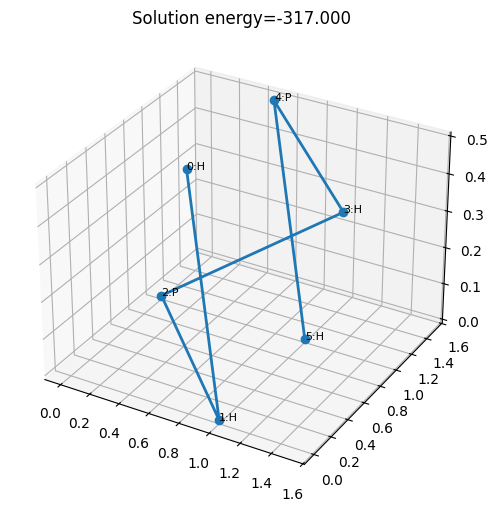

In [13]:
from mpl_toolkits.mplot3d import Axes3D

xs, ys, zs = [], [], []
labels = []
for i in range(num_residues):
    c = coords_positions[i]
    if c[0] is None:
        xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    else:
        xs.append(c[0]); ys.append(c[1]); zs.append(c[2])
    labels.append(f"{i}:{protein_sequence[i]}")

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, marker='o', linewidth=2)
for i,(x,y,z) in enumerate(zip(xs, ys, zs)):
    if not np.isnan(x):
        ax.text(x, y, z, labels[i], size=8)
ax.set_title(f"Solution energy={best_E:.3f}")
plt.show()


## Conclusion & Next Steps

This notebook demonstrates:
- Encoding HP model constraints as a Pauli-sum Hamiltonian
- Fast classical evaluation of candidate solutions
- Heuristic optimization pipelines


